In [1]:
!pip install matplotlib numpy tensorboard standard-imghdr torchnet

You should consider upgrading via the '/home/kevin/.pyenv/versions/3.8.10/bin/python3.8 -m pip install --upgrade pip' command.


In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.dataset import Dataset
from PIL import Image, ImageDraw, ImageFont
from ImageToStringNet import ImageToStringNet, classes

from sklearn.metrics import accuracy_score

In [2]:
print("Classes: ", len(classes))

class DigitDataset(Dataset):
	def __init__(self, imgs_path, txt_path, transform=None):
		self.imgs_path = imgs_path
		self.images = np.loadtxt(txt_path, dtype=str, delimiter='\t', comments=[])
		self.transform = transform
		self.targets = [classes.index(c) for _, c, _, _ in self.images]
		self.targets = torch.LongTensor(self.targets)
		
		self.data = [Image.open(f'{self.imgs_path}/{i}').convert('L') for i, _, _, _ in self.images]
		self.data = [self.transform(i) for i in self.data]
		self.data = torch.stack(self.data, dim=0)

	def __getitem__(self, index):
		_, _, t, b = self.images[index]

		# Image Tensor, Label, Top Margin (%), Bottom Margin (%)
		return self.data[index], self.targets[index], np.float32(t), np.float32(b)

	def __len__(self):
		return len(self.images)

Classes:  96


In [3]:
# transforms
transform = transforms.Compose(
	[transforms.ToTensor(),
	transforms.Normalize((0.5,), (0.5,))])

dataset_dir = "../dataset/digit_dataset"
trainset = DigitDataset(imgs_path=dataset_dir, txt_path="../dataset/digit_dataset/train.txt", transform=transforms.ToTensor())
testset = DigitDataset(imgs_path=dataset_dir, txt_path="../dataset/digit_dataset/test.txt", transform=transforms.ToTensor())

# dataloaders
batch_size = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
										shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
										shuffle=False, num_workers=2)

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
	if one_channel:
		img = img.mean(dim=0)
	img = img / 2 + 0.5     # unnormalize
	npimg = img.numpy()
	if one_channel:
		plt.imshow(npimg, cmap="Greys")
	else:
		plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [4]:
net = ImageToStringNet()

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/exp1')

In [7]:
dataiter = iter(trainloader)
next(dataiter)[0].shape

torch.Size([256, 1, 28, 28])

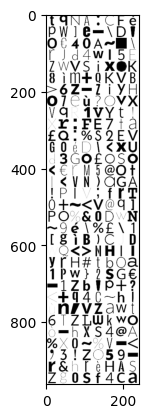

In [8]:
# get some random training images
dataiter = iter(trainloader)
images, labels, t, b = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_img-to-str_images', img_grid)

tensorboard --logdir=runs

In [9]:
writer.add_graph(net, (images, t, b))
writer.close()

In [10]:
# helper function
def select_n_random(data, labels, n=100):
	'''
	Selects n random datapoints and their corresponding labels from a dataset
	'''
	assert len(data) == len(labels)

	perm = torch.randperm(len(data))
	return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)
print("Images shape: ", images.shape)
print("Labels shape: ", labels.shape)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
					metadata=class_labels,
					label_img=images)
writer.close()

Images shape:  torch.Size([100, 1, 28, 28])
Labels shape:  torch.Size([100])


In [11]:
# helper functions

def images_to_probs(net, images, top_margin, bottom_margin):
	'''
	Generates predictions and corresponding probabilities from a trained
	network and a list of images
	'''
	output = net(images, top_margin, bottom_margin)
	# convert output probabilities to predicted class

	output = output.cpu()

	_, preds_tensor = torch.max(output, 1)
	preds = np.squeeze(preds_tensor.numpy())
	return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels, top_margin, bottom_margin):
	'''
	Generates matplotlib Figure using a trained network, along with images
	and labels from a batch, that shows the network's top prediction along
	with its probability, alongside the actual label, coloring this
	information based on whether the prediction was correct or not.
	Uses the "images_to_probs" function.
	'''
	preds, probs = images_to_probs(net, images, top_margin, bottom_margin)
	# plot the images in the batch, along with predicted and true labels

	images = images.cpu()

	fig = plt.figure(figsize=(12, 48))
	for idx in np.arange(4):
		ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
		matplotlib_imshow(images[idx], one_channel=True)
		ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
			classes[preds[idx]],
			probs[idx] * 100.0,
			classes[labels[idx]]),
					color=("green" if preds[idx]==labels[idx].item() else "red"))
	return fig

In [12]:
if torch.xpu.is_available():
	net = net.xpu()

In [13]:
class AverageValueMeter():
	def __init__(self):
		self.reset()
	
	def reset(self):
		self.sum = 0
		self.num = 0
	
	def add(self, value, num):
		self.sum += value * num
		self.num += num
	
	def value(self):
		try:
			return self.sum / self.num
		except:
			return None

In [14]:
loss_meter = AverageValueMeter()
accuracy_meter = AverageValueMeter()

global_step = 0
for epoch in range(50):  # loop over the dataset multiple times
	print(f'Epoch {epoch + 1}')
	for mode in ["train", "test"]:
		loss_meter.reset()
		accuracy_meter.reset()
		for i, data in enumerate(trainloader if mode == "train" else testloader, 0):
			global_step += batch_size
			with torch.set_grad_enabled(mode == "train"):
				# get the inputs; data is a list of [inputs, labels]

				inputs, labels, t, b = data
				if torch.xpu.is_available():
					inputs, labels, t, b = inputs.xpu(), labels.xpu(), t.xpu(), b.xpu()


				# forward + backward + optimize
				outputs = net(inputs, t, b)
				loss = criterion(outputs, labels)

				if mode == "train":
					loss.backward()
					optimizer.step()
					optimizer.zero_grad()

				loss_meter.add(loss.item(), inputs.size(0))
				accuracy_meter.add(accuracy_score(labels.cpu(), outputs.cpu().max(1)[1]), inputs.size(0))

				if i % 10 == 9:
					writer.add_scalar(f'loss/{mode}',
									loss_meter.value(),
									global_step)
					writer.add_scalar(f'accuracy/{mode}',
									accuracy_meter.value(),
									global_step)

				# ...log a Matplotlib Figure showing the model's predictions on a
				# random mini-batch
		print(f'[{mode}]\tLoss: {loss_meter.value():.4f}, Accuracy: {accuracy_meter.value():.4f}')
	if mode == "test":
		writer.add_figure('predictions vs. actuals',
						plot_classes_preds(net, inputs, labels, t, b),
						global_step)

print('Finished Training')

Epoch 1
[train]	Loss: 4.5373, Accuracy: 0.0213
[test]	Loss: 4.5069, Accuracy: 0.0306
Epoch 2
[train]	Loss: 4.5050, Accuracy: 0.0336
[test]	Loss: 4.5314, Accuracy: 0.0258
Epoch 3
[train]	Loss: 4.4938, Accuracy: 0.0284
[test]	Loss: 4.3041, Accuracy: 0.0295
Epoch 4
[train]	Loss: 3.8745, Accuracy: 0.1428
[test]	Loss: 2.4237, Accuracy: 0.4720
Epoch 5
[train]	Loss: 1.3039, Accuracy: 0.6685
[test]	Loss: 0.7623, Accuracy: 0.7881
Epoch 6
[train]	Loss: 0.6470, Accuracy: 0.8064
[test]	Loss: 0.6536, Accuracy: 0.7990
Epoch 7
[train]	Loss: 0.5015, Accuracy: 0.8434
[test]	Loss: 0.6228, Accuracy: 0.8120
Epoch 8
[train]	Loss: 0.4224, Accuracy: 0.8630
[test]	Loss: 0.6813, Accuracy: 0.8225
Epoch 9
[train]	Loss: 0.3753, Accuracy: 0.8774
[test]	Loss: 0.6089, Accuracy: 0.8368
Epoch 10
[train]	Loss: 0.3292, Accuracy: 0.8895
[test]	Loss: 0.5952, Accuracy: 0.8412
Epoch 11
[train]	Loss: 0.3045, Accuracy: 0.8971
[test]	Loss: 0.6422, Accuracy: 0.8271
Epoch 12
[train]	Loss: 0.2735, Accuracy: 0.9051
[test]	Loss: 0.

In [ ]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_label = []
with torch.no_grad():
	for data in testloader:
		images, labels, t, b = data

		if torch.xpu.is_available():
			images, t, b = images.xpu(), t.xpu(), b.xpu()

		output = net(images, t, b)

		output = output.cpu()

		class_probs_batch = [F.softmax(el, dim=0) for el in output]

		class_probs.append(class_probs_batch)
		class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
	'''
	Takes in a "class_index" from 0 to 9 and plots the corresponding
	precision-recall curve
	'''
	tensorboard_truth = test_label == class_index
	tensorboard_probs = test_probs[:, class_index]

	writer.add_pr_curve(classes[class_index],
						tensorboard_truth,
						tensorboard_probs,
						global_step=global_step)
	writer.close()

# plot all the pr curves
for i in range(len(classes)):
	add_pr_curve_tensorboard(i, test_probs, test_label)

In [15]:
torch.save(net.state_dict(), 'model_weights_v2.pth')

# ---

In [ ]:
import torch

if torch.xpu.is_available():
	print("Using Intel GPU (XPU)")
else:
	print("No supported GPU backend detected")

Using Intel GPU (XPU)


In [33]:
import torch.nn as nn
import torch.nn.functional as F

conv1 = nn.Conv2d(1, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)
fc1 = nn.Linear(16 * 4 * 4, 120)
fc2 = nn.Linear(120, 84)
fc3 = nn.Linear(84, 10)

In [34]:
trainloader.dataset

In [35]:
img = torch.rand(1,28,28)
x = conv1(img)
print("conv1:",x.shape)

x = F.relu(x)
print("F.relu:",x.shape)

x = pool(x)
print("pool:",x.shape)

x = conv2(x)
print("conv2:",x.shape)

x = F.relu(x)
print("F.relu:",x.shape)

x = pool(x)
print("pool:",x.shape)

x.view(-1, 16 * 4 * 4).shape

conv1: torch.Size([6, 24, 24])
F.relu: torch.Size([6, 24, 24])
pool: torch.Size([6, 12, 12])
conv2: torch.Size([16, 8, 8])
F.relu: torch.Size([16, 8, 8])
pool: torch.Size([16, 4, 4])


torch.Size([1, 256])